In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Load the dataset
df = pd.read_csv('../data/house.csv')

In [3]:
df.sample(3)

,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
3127,7,131.161252,1903.05,150.610760,1,31,94145.345404
954,2,52.539034,1439.47,122.923899,2,53,90840.938042
965,2,56.646374,1292.43,154.543573,7,35,94158.427788


In [4]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    4308 non-null   int64  
 1   net_sqm          4308 non-null   float64
 2   center_distance  4308 non-null   float64
 3   metro_distance   4308 non-null   float64
 4   floor            4308 non-null   int64  
 5   age              4308 non-null   int64  
 6   price            4308 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 235.7 KB


In [4]:
# Display summary statistics of the dataset
df.describe()



,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,3.732823,118.941327,1090.544301,105.665358,9.397168,48.576834,95701.196185
std,2.476989,95.469802,555.325830,60.750825,7.517018,27.621465,3919.823988
min,1.000000,10.244518,11.800000,1.245338,1.000000,0.000000,86113.592974
25%,2.000000,52.240659,635.897500,56.156897,2.000000,25.000000,92934.251436
50%,3.000000,91.828201,1143.135000,101.388012,8.000000,48.000000,95337.792918
75%,5.000000,150.987591,1554.280000,148.481068,16.000000,72.000000,97980.675094
max,17.000000,750.971604,1999.840000,330.275317,24.000000,97.000000,118134.771190


In [5]:
# Check for missing values
df.isnull().sum()

bedroom_count      0
net_sqm            0
center_distance    0
metro_distance     0
floor              0
age                0
price              0
dtype: int64

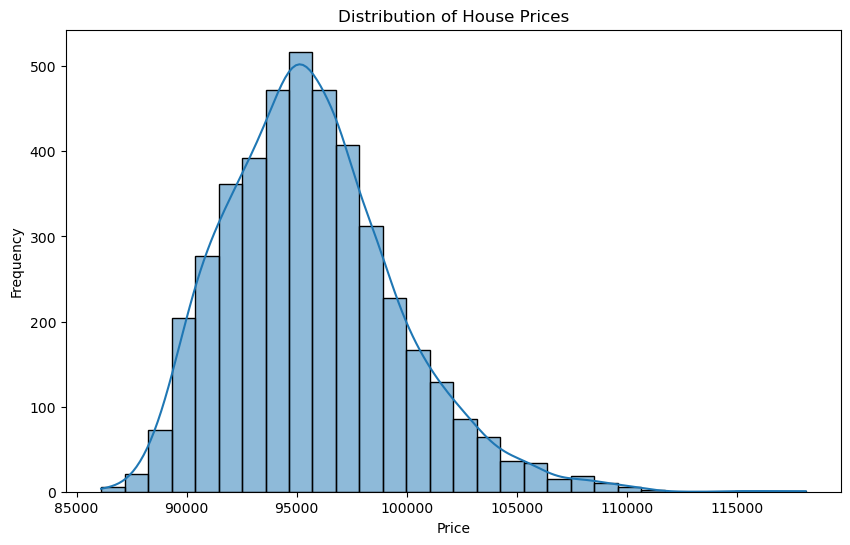

In [6]:
# Visualize the distribution of the target variable (price)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

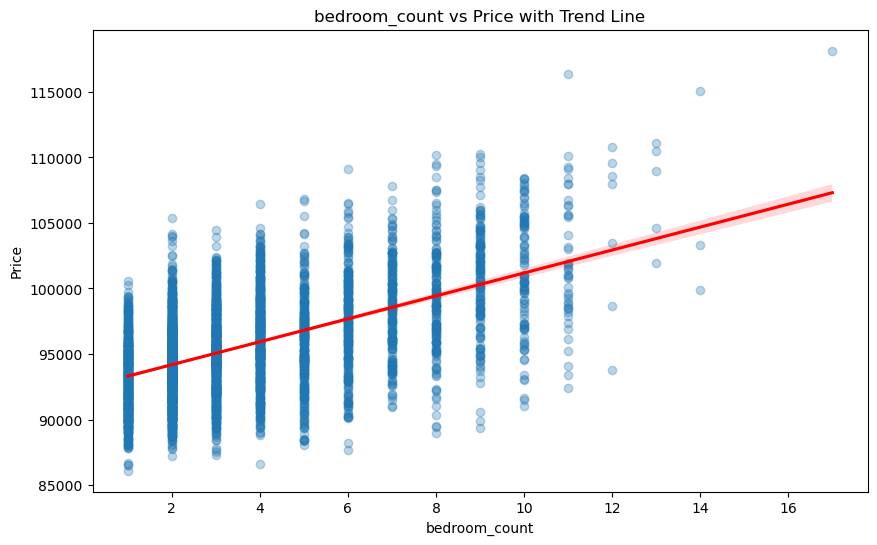

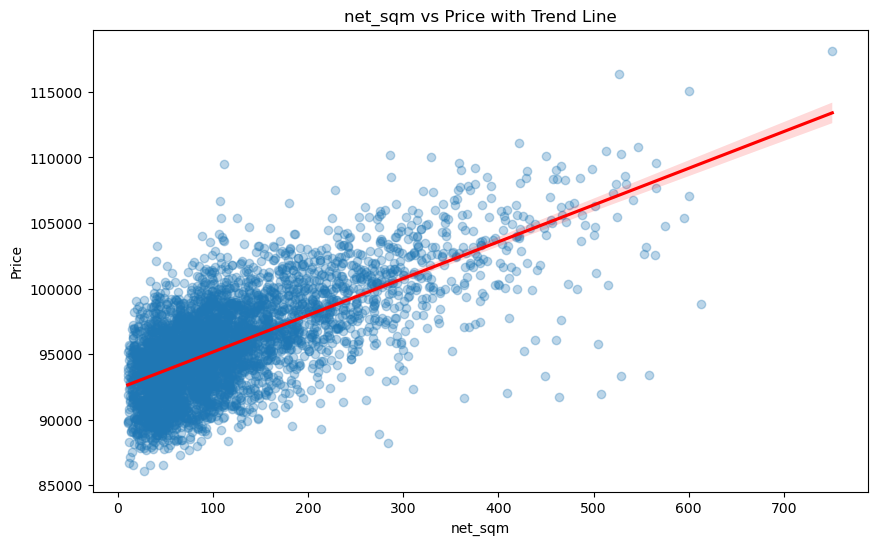

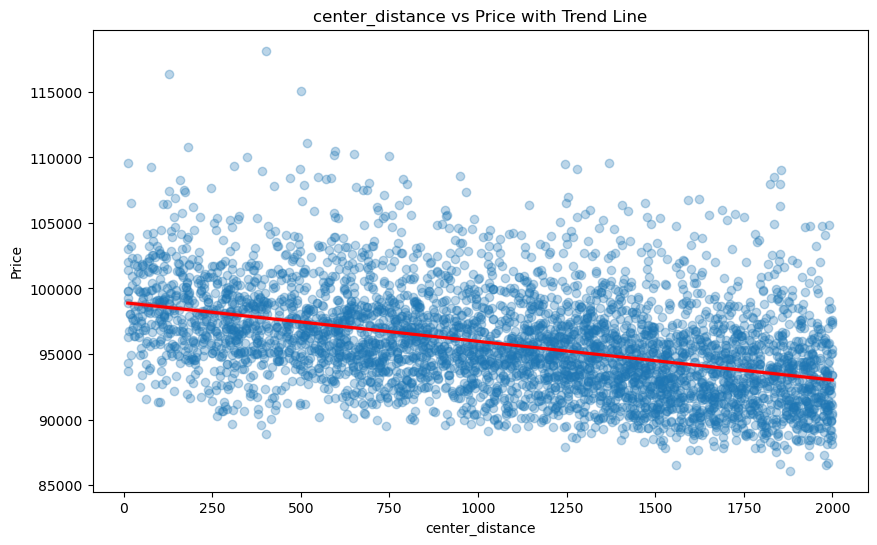

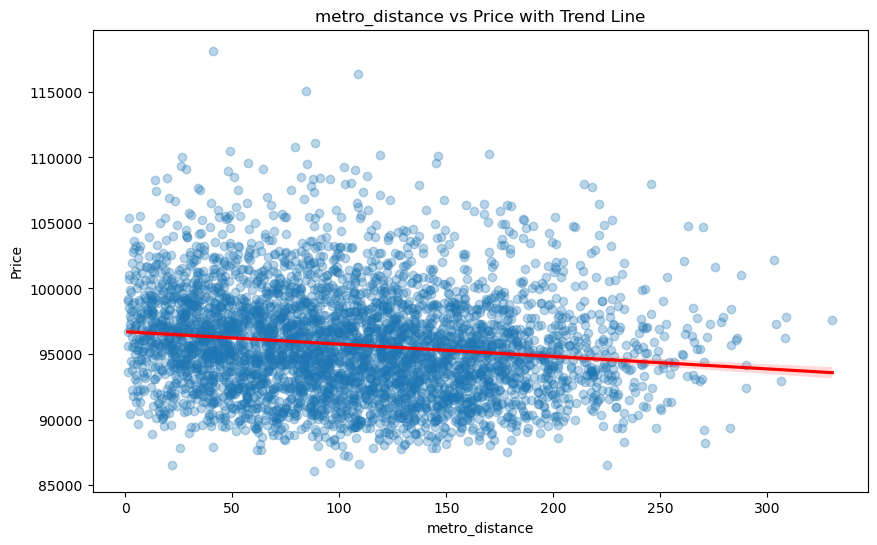

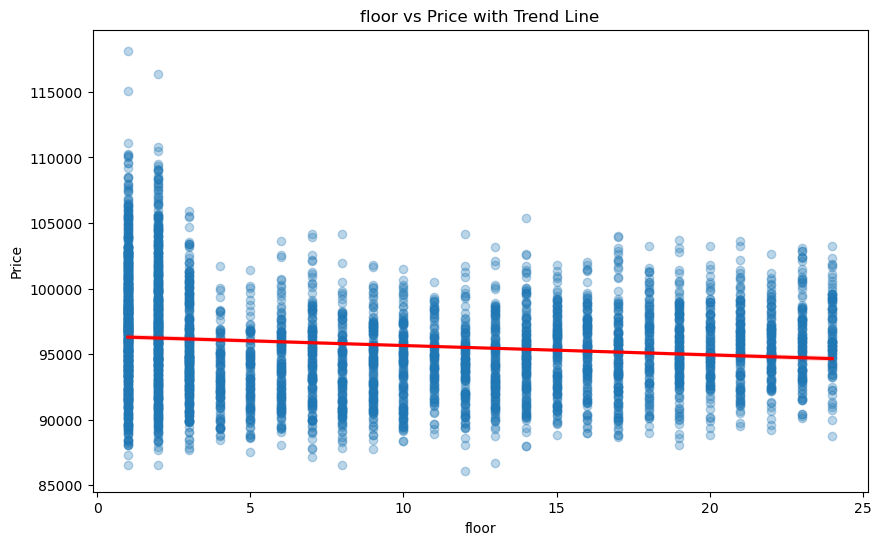

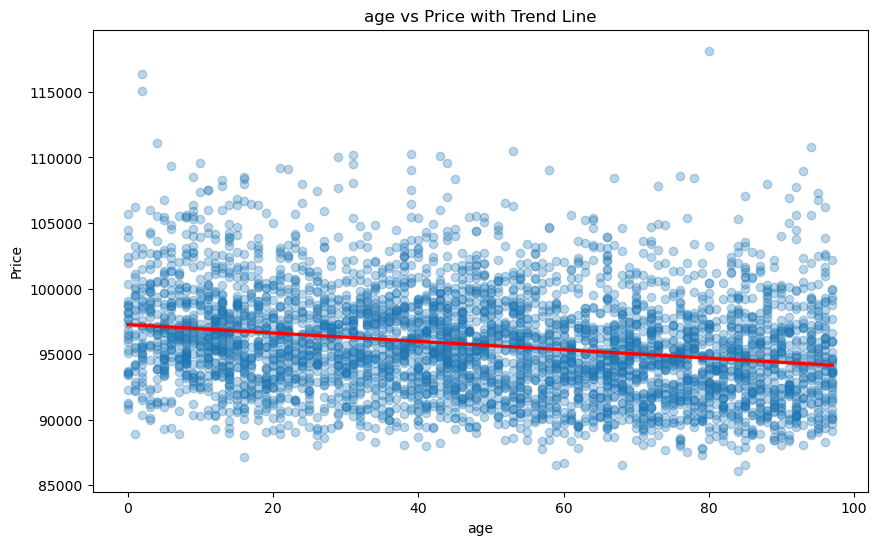

In [7]:
# Loop through features and create scatter plots with trend lines
features = ['bedroom_count', 'net_sqm', 'center_distance', 'metro_distance', 'floor', 'age']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=df[feature], y=df['price'], scatter_kws={'alpha':0.3}, line_kws={"color":"r"})
    plt.title(f'{feature} vs Price with Trend Line')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

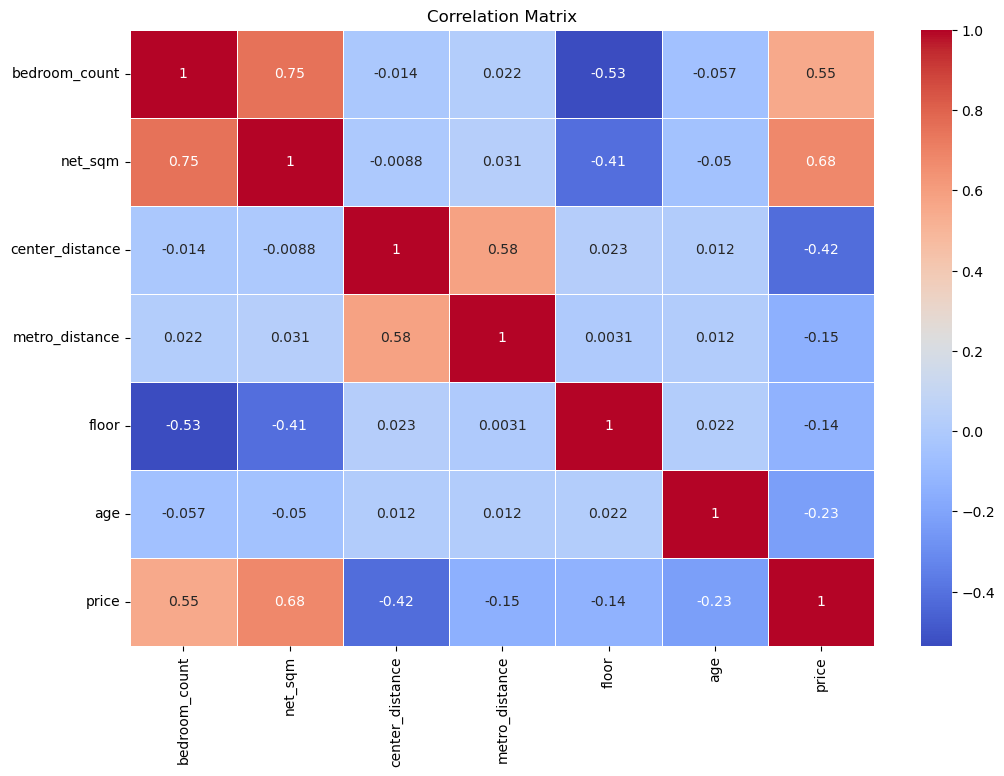

In [8]:
# Calculate and visualize the correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

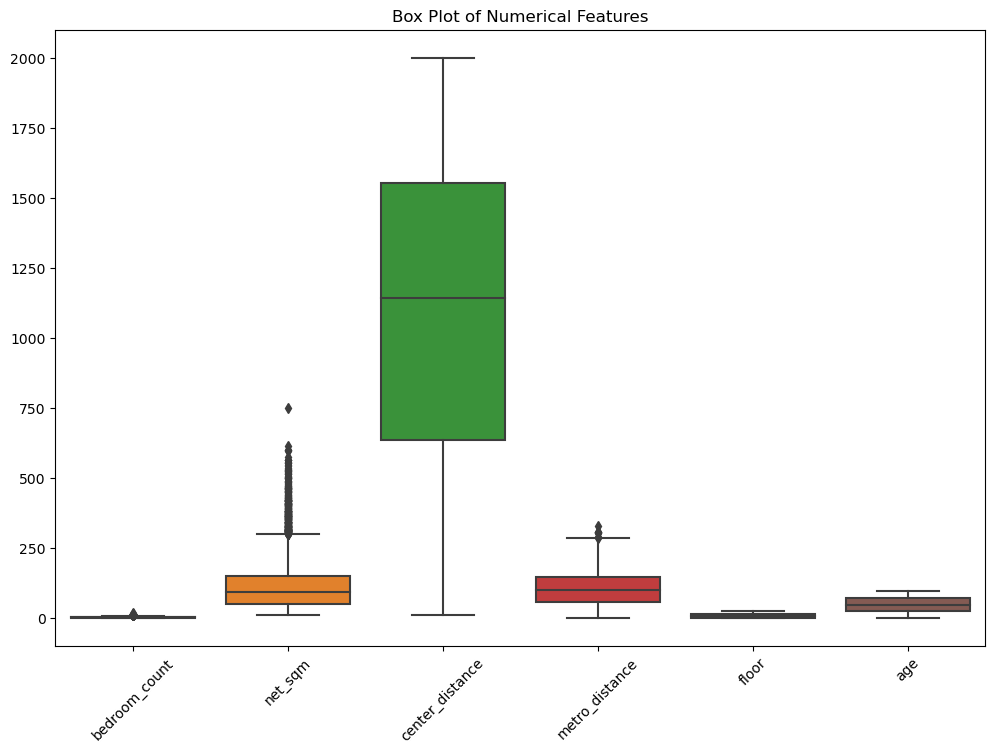

In [10]:
# Box Plot for Numerical Features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[features])
plt.title('Box Plot of Numerical Features')
plt.xticks(rotation=45)
plt.show()


In [11]:
# Get the correlation of each feature with the target variable 'price'
correlation_with_target = corr['price'].abs().sort_values(ascending=False)
print(correlation_with_target)

price              1.000000
net_sqm            0.681987
bedroom_count      0.552405
center_distance    0.418161
age                0.225119
metro_distance     0.146373
floor              0.136713
Name: price, dtype: float64


##### Based on the correlation matrix, we observe that net_sqm, bedroom_count, and center_distance have the highest correlation with price. We will start by training a linear regression model using these top 3 features. After establishing a baseline, we will iteratively add other features (age, metro_distance, and floor) to check if they improve the model's performance. This approach helps us identify the most informative features for predicting house prices.


In [12]:
# Select top 3 features with highest correlation with the target variable 'price'
top_3_features = correlation_with_target.index[1:4].tolist()
print("Top 3 features:", top_3_features)

# Separate the features and the target variable
X = df[top_3_features]
y = df['price']


Top 3 features: ['net_sqm', 'bedroom_count', 'center_distance']


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the base model with top 3 features
base_model = LinearRegression()
base_model.fit(X_train, y_train)

# Predict and evaluate the base model
y_pred = base_model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Model - MSE: {base_mse}, R²: {base_r2}")


Base Model - MSE: 5158086.057644455, R²: 0.6534000439750194


In [17]:
from itertools import combinations

# Get the remaining features
remaining_features = [feature for feature in df.columns if feature not in top_3_features + ['price']]
print("Remaining features:", remaining_features)

best_model = base_model
best_mse = base_mse
best_r2 = base_r2
best_features = top_3_features

# Iterate through combinations of the remaining features (1, 2, and 3 additional features)
for i in range(1, 4):
    for combo in combinations(remaining_features, i):
        # Add the combination of features to the current set of features
        current_features = top_3_features + list(combo)
        
        # Prepare the data
        X_current = df[current_features]
        X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, random_state=42)
        
        # Train the model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Check if the new model is better
        if r2 > best_r2:
            best_model = model
            best_mse = mse
            best_r2 = r2
            best_features = current_features

        print(f"Model with {combo} - MSE: {mse}, R²: {r2}")

print(f"Best Model - Features: {best_features}, MSE: {best_mse}, R²: {best_r2}")


Remaining features: ['metro_distance', 'floor', 'age']
Model with ('metro_distance',) - MSE: 5035299.323962607, R²: 0.6616507548043795
Model with ('floor',) - MSE: 4631339.766465891, R²: 0.6887950023604532
Model with ('age',) - MSE: 4688335.4724444235, R²: 0.684965149782384
Model with ('metro_distance', 'floor') - MSE: 4507318.664882776, R²: 0.6971286571065136
Model with ('metro_distance', 'age') - MSE: 4569203.938115, R²: 0.6929702478164838
Model with ('floor', 'age') - MSE: 4149507.6228142395, R²: 0.7211719340236193
Model with ('metro_distance', 'floor', 'age') - MSE: 4028777.9852626217, R²: 0.7292844173359687
Best Model - Features: ['net_sqm', 'bedroom_count', 'center_distance', 'metro_distance', 'floor', 'age'], MSE: 4028777.9852626217, R²: 0.7292844173359687


##### Based on the iterative feature addition, the best model includes all the features: net_sqm, bedroom_count, center_distance, metro_distance, floor, and age. This model achieved an R² score of 0.729, indicating that approximately 72.9% of the variance in house prices can be explained by these features. The Mean Squared Error (MSE) for this model is 4,028,777, which is the lowest among the tested combinations, demonstrating improved prediction accuracy.


In [ ]:
# Separate the features and the target variable
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model with all features
model = LinearRegression()
model.fit(X_train, y_train)


Full Model - MSE: 4028777.9852626272, R²: 0.7292844173359683


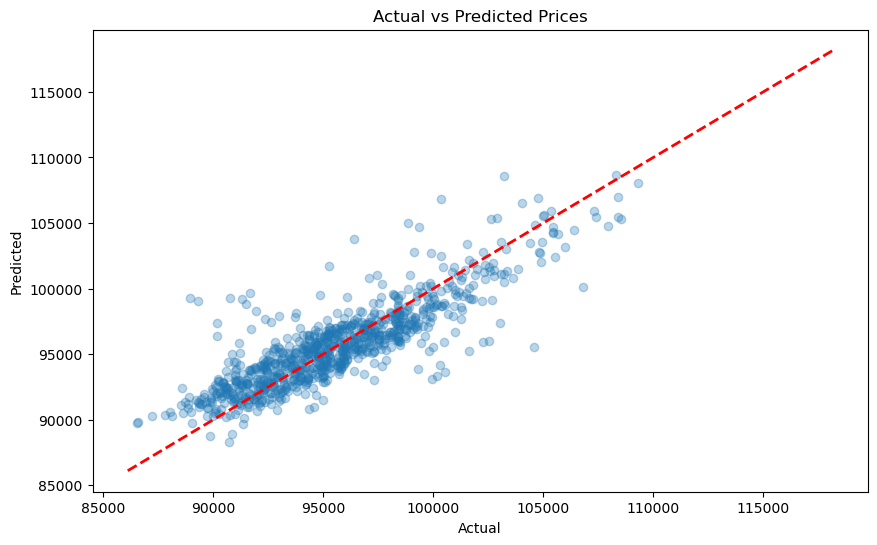

In [16]:
# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Full Model - MSE: {mse}, R²: {r2}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.show()

